In [44]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
import os
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, \
AveragePooling2D, MaxPooling2D

# Datasets Loading

In [2]:
def load_dataset(data_path, max_species=100, shuffled=True, grayscale=False,
                 flatten=False):
    
    data_images = []
    data_labels = []
    
    for num_species, specie in enumerate(os.listdir(data_path)):
        images_path = os.path.join(data_path, specie)
        for i in os.listdir(images_path):
            image_path = os.path.join(images_path, i)
            im = Image.open(image_path)
            
            if grayscale:
                im = im.convert("L")
            arr = np.asarray(im)
            
            if flatten:
                arr = arr.flatten()
            data_images.append(arr)
            data_labels.append(specie)
            
        if num_species == max_species-1:
            break
            
    data_images = np.array(data_images)
    data_labels = np.array(data_labels)
    
    if shuffled:
        X, y = shuffle(data_images, data_labels, random_state=1)
        
    return X, y

Paths to train, validation and test sets:

In [6]:
train_path = 'data/200_species_train'
valid_path = 'data/200_species_valid/'
test_path = 'data/200_species_test/'

Let's define the **maximal number of species to be currently classified**:

In [32]:
N_SPECIES = 100

Now load the datasets:

In [33]:
X_train, y_train = load_dataset(train_path, max_species=N_SPECIES)
X_valid, y_valid = load_dataset(valid_path, max_species=N_SPECIES)
X_test,  y_test  = load_dataset(test_path,  max_species=N_SPECIES)

In [34]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((13693, 224, 224, 3),
 (13693,),
 (500, 224, 224, 3),
 (500,),
 (500, 224, 224, 3),
 (500,))

Converting the labels into *one-hot* representation:

In [35]:
lenc = LabelEncoder()
y_train = to_categorical( lenc.fit_transform(y_train) )
y_valid = to_categorical( lenc.transform(y_valid) )
y_test  = to_categorical( lenc.transform(y_test) )

In [36]:
y_train.shape, y_valid.shape, y_test.shape

((13693, 100), (500, 100), (500, 100))

And normalizing all pixels values into the range of 0-1 (instead of 0-255):

In [37]:
X_train = X_train / 255
X_valid = X_valid / 255
X_test  = X_test / 255

Let's examine one picture to make sure things are working:

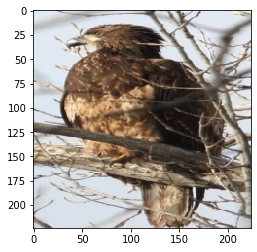

In [43]:
plt.imshow(X_train[0]);

# LeNet

The LeNet CNN is constructed as following:
* A convolution layer of 6 filters, each of size 5x5, with *tanh* activation fanction (let's call it C1). Get the 32x32x3 images as inputs.
* An average pooling layer of size 2x2 and strides of 2x2 (named S2).
* Another convolution layer of 16 filters, each of size 5x5, with *tanh* activation fanction (C3).
* Another average pooling layer of size 2x2 and strides of 1x1 (named S4).
* A convolution layer of 120 filters, each of size 5x5, with *tanh* activation fanction (C5).
* A flatten layer, put to allow the use of fully-conected (dense) layers (will be called "flat").
* A fully-connected layer of 84 neurons with *tanh* activation function (named FC6).
* A fully-connected layer of 10 neurons (as the number of possible labels), with a *softmax* activation function (named "out").

In [38]:
lenet = Sequential()

lenet.add( Conv2D(filters=6, kernel_size=5, activation="tanh",
                  input_shape=(X_train.shape[1], X_train.shape[2],
                               X_train.shape[3]),
                  name='C1') )

lenet.add( AveragePooling2D(pool_size=2, strides=2, name="S2") )

lenet.add( Conv2D(filters=16, kernel_size=5, activation="tanh", name="C3") )

lenet.add( AveragePooling2D(pool_size=2, strides=2, name="S4") )

lenet.add( Conv2D(filters=120, kernel_size=5, activation="tanh", name="C5") )

lenet.add( Flatten(name="flat") )

lenet.add( Dense(84, activation="tanh", name="FC6") )

lenet.add( Dense(N_SPECIES, activation="softmax", name="Out") )

Let's examine our model:

In [39]:
lenet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 220, 220, 6)       456       
_________________________________________________________________
S2 (AveragePooling2D)        (None, 110, 110, 6)       0         
_________________________________________________________________
C3 (Conv2D)                  (None, 106, 106, 16)      2416      
_________________________________________________________________
S4 (AveragePooling2D)        (None, 53, 53, 16)        0         
_________________________________________________________________
C5 (Conv2D)                  (None, 49, 49, 120)       48120     
_________________________________________________________________
flat (Flatten)               (None, 288120)            0         
_________________________________________________________________
FC6 (Dense)                  (None, 84)               

The model will be using **categorical cross-entropy** as a loss function, an **Adam** optimizer and **accuracy, precision and recall** as the metrics to be evaluated by:

In [40]:
lenet.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["acc", "Precision", "Recall"])

We can now train our model. Let's try **batches of 32**, **10 epochs** and using the **validation set** to validate the model:

In [41]:
results = lenet.fit( X_train, y_train, batch_size=32, epochs=10,
                     validation_data=(X_valid, y_valid),
                     use_multiprocessing=True )

Train on 13693 samples, validate on 500 samples
Epoch 1/10
13693/13693 [==============================] - 584s 43ms/sample - loss: 4.6502 - acc: 0.0163 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 4.6509 - val_acc: 0.0100 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
13693/13693 [==============================] - 590s 43ms/sample - loss: 4.6222 - acc: 0.0153 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 4.6523 - val_acc: 0.0100 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
13693/13693 [==============================] - 591s 43ms/sample - loss: 4.6234 - acc: 0.0145 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 4.6522 - val_acc: 0.0100 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/10
13693/13693 [==============================] - 589s 43ms/sample - loss: 4.6235 - acc: 0.0148 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 4.6621 - val_acc: 0.0100 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e

The network gave extremely poor result! Must use other configurations.

# Trying Custom-Made CNN:

In [51]:
try_net = Sequential()

try_net.add( Conv2D(filters=128, kernel_size=5, activation="relu",
                    input_shape=(X_train.shape[1], X_train.shape[2],
                                 X_train.shape[3]),
                    name='C1') )

try_net.add( MaxPooling2D(pool_size=2, strides=2, name="S2") )

try_net.add( Conv2D(filters=64, kernel_size=5, activation="relu", name="C3") )

try_net.add( MaxPooling2D(pool_size=2, strides=2, name="S4") )

try_net.add( Conv2D(filters=64, kernel_size=5, activation="relu", name="C5") )

try_net.add( MaxPooling2D(pool_size=2, strides=2, name="S6") )

try_net.add( Conv2D(filters=64, kernel_size=5, activation="relu", name="C7") )

try_net.add( MaxPooling2D(pool_size=2, strides=2, name="S8") )

try_net.add( Conv2D(filters=128, kernel_size=5, activation="relu", name="C9") )

try_net.add( Flatten(name="flat") )

try_net.add( Dense(N_SPECIES, activation="relu", name="FC10") )

try_net.add( Dense(N_SPECIES, activation="softmax", name="Out") )

In [52]:
try_net.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 220, 220, 128)     9728      
_________________________________________________________________
S2 (MaxPooling2D)            (None, 110, 110, 128)     0         
_________________________________________________________________
C3 (Conv2D)                  (None, 106, 106, 64)      204864    
_________________________________________________________________
S4 (MaxPooling2D)            (None, 53, 53, 64)        0         
_________________________________________________________________
C5 (Conv2D)                  (None, 49, 49, 64)        102464    
_________________________________________________________________
S6 (MaxPooling2D)            (None, 24, 24, 64)        0         
_________________________________________________________________
C7 (Conv2D)                  (None, 20, 20, 64)       

In [50]:
try_results = lenet.fit( X_train, y_train, batch_size=32, epochs=10,
                         validation_data=(X_valid, y_valid),
                         use_multiprocessing=True )

Train on 13693 samples, validate on 500 samples
Epoch 1/10
13693/13693 [==============================] - 581s 42ms/sample - loss: 4.6226 - acc: 0.0155 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 4.6588 - val_acc: 0.0100 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
13693/13693 [==============================] - 562s 41ms/sample - loss: 4.6222 - acc: 0.0137 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 4.6611 - val_acc: 0.0100 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
  480/13693 [>.............................] - ETA: 9:03 - loss: 4.6160 - acc: 0.0134 - Precision: 0.0000e+00 - Recall: 0.0000e+00

KeyboardInterrupt: 

In [55]:
from tensorflow.experimental import list_physical_devices
print("Num GPUs Available: ", len(list_physical_devices('GPU')))

ModuleNotFoundError: No module named 'tensorflow.experimental'